In [42]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Create a data frame to store the dataset and use number to represent a class
# root: dataset root
# matrix_label: a list for storing confusion matrix label
def initImg(root, matrix_label):
    label_lst = []
    class_lst = []
    img_lst = []
    label = 0
    for file in os.listdir(root):
        class_path = os.path.join(root, file)
        for fn in os.listdir(class_path):
            img_path = os.path.join(class_path, fn)
            img_lst.append(img_path)
            class_lst.append(file)
            if file not in matrix_label:
                matrix_label.append(file)
            label_lst.append(label)
        label += 1

    return pd.DataFrame({
        "filename": img_lst,
        "class": class_lst,
        "label": label_lst
    })

def preprocessImg(img):
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    sharpened = cv2.addWeighted(img, 1, laplacian, 1.0, 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(sharpened)
    return clahe_img

In [37]:
#two essential functions for knn method
def build_bow_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)

    descriptors = np.asarray(descriptors, dtype=np.float32)
    words = kmeans.predict(descriptors)

    histogram, _ = np.histogram(words, bins=np.arange(n_clusters + 1))

    return histogram

def get_descriptors(img_path, preprocess=True):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if preprocess:
        gray = preprocessImg(gray)

    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray, None)

    return descriptors

In [38]:
root_dir = 'Aerial_Landscapes'
matrix_lst = []
df = initImg(root_dir, matrix_lst)

In [39]:
def descriptorlst(train_df):
    descriptor_lst = []

    for _, row in train_df.iterrows():
        descriptors = get_descriptors(row['filename'], preprocess=True)
        if descriptors is not None:
            descriptor_lst.extend(descriptors)
    descriptor_lst = np.asarray(descriptor_lst, dtype=np.float32)

    return descriptor_lst

# classifier: knn or sgd method
def dataloader(classifier):
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )
    if classifier == 'knn':
        descriptor_lst = descriptorlst(train_df)
        kmeans = MiniBatchKMeans(n_clusters=100, random_state=42)
        kmeans.fit(descriptor_lst)
    data_type = ['train_df', 'test_df']
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for ele in data_type:
        if ele == 'train_df':
            data = train_df
        elif ele == 'test_df':
            data = test_df

        if classifier == 'knn':
            for _, row in data.iterrows():
                descriptors = get_descriptors(row['filename'], preprocess=False)
                hist = build_bow_histogram(descriptors, kmeans, 100)
                if ele == 'train_df':
                    X_train.append(hist)
                    y_train.append(row['label'])
                else:
                    X_test.append(hist)
                    y_test.append(row['label'])

        elif classifier == 'sgd':
            for _, row in data.iterrows():
                img = cv2.imread(row['filename'])
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                normed_img = gray_img.astype(np.float32) / 255.0
                if ele == 'train_df':
                    X_train.append(normed_img.flatten())
                    y_train.append(row['label'])
                else:
                    X_test.append(normed_img.flatten())
                    y_test.append(row['label'])

    return X_train, y_train, X_test, y_test

training complete


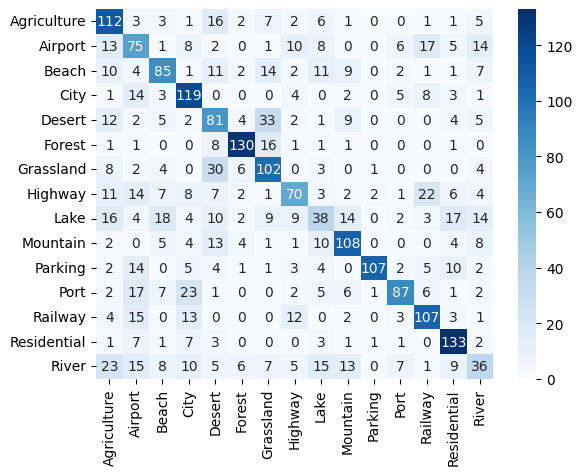

Test Accuracy: 0.5791666666666667


In [40]:
X_train, y_train, X_test, y_test = dataloader('knn')

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("training complete")

# Predict and evaluate
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_lst, yticklabels=matrix_lst)
plt.show()
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Training complete !


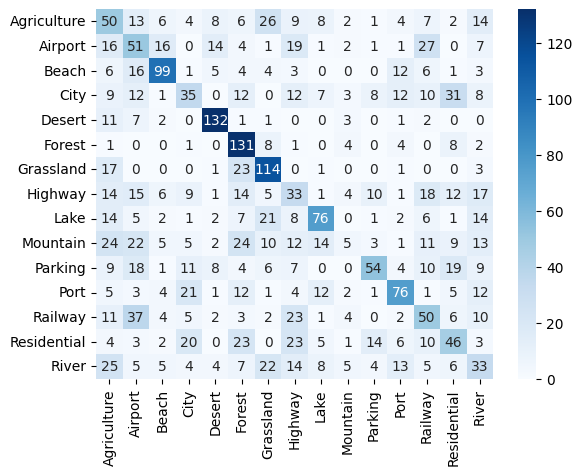

Test Accuracy: 0.41041666666666665


In [44]:
X_train, y_train, X_test, y_test = dataloader('sgd')

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("Training complete !")

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_lst, yticklabels=matrix_lst)
plt.show()
print("Test Accuracy:", accuracy_score(y_test, y_pred))
